In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import ascii
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightkurve as lk
from sklearn.inspection import permutation_importance
import math as m
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import LS_modular
import bls_modular
import seaborn as sns
import glob
#rf-3 specific
from astroquery.mast import Catalogs 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import Useful_functions as uf
plt.rcParams.update(plt.rcParamsDefault)#--reset defaults if needed



/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#inputs

rf1_features_list = ['rvar',
                 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3',
                 'Vmag','Tmag','CLASS']#, 'RA_orig', 'Dec_orig']
rf1_tree_params = []
rf1_cv_params = []
#rf2
rf2_features_list = ['rvar',
                 
                 'power_bls', 'period_bls', 'depth_bls', 'tt_bls', 'dur_bls',
                 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3',
                 'Vmag','Tmag','CLASS']#,'RA_orig','Dec_orig']
rf2_tree_params = []
rf2_cv_params = []
#rf3
using_tolerance = .15 #amount of disagreement betwn mine & MQ's Prot to still match
rf3_features_list = [ 'rvar', 'ls-1', 'ls-2', 'ls-3', 
                     'lsamp-1', 'lsamp-2', 'lsamp-3','Label','contratio']
rf3_tree_params = []
rf3_cv_params = []

# RF-1 model

In [3]:
## RF-1

print('starting RF-1')
#load data 
# allstats = pd.read_csv('data/master_data.csv')
allstats = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/master_df.csv')#includes ncvz google df & tois in rf2
# examples = allstats[np.isnan(allstats['CLASS'])==False]

mqdata = pd.read_csv('mcquillan_sample.csv')
#select features
# rf1_features = examples[(examples['CLASS']==1) | (examples['CLASS']==5)] #only keep CVZ periodic(1) or flat(5) labels for RF1
rf1_features = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/rf1_training.csv')#includes ncvz google df & tois in rf2
rf1_short_features_nans = rf1_features[rf1_features_list]
rf1_short_features = rf1_short_features_nans.dropna()
rf1_nan_exs_loss = len(rf1_short_features_nans) - len(rf1_short_features)
np.random.seed(seed = 11)
rf1_short_features['random'] = np.random.random(size = len(rf1_short_features))
#model prep summary
rf1_final_labels = rf1_short_features['CLASS'].to_numpy()
rf1_final_features = rf1_short_features.drop(columns=['CLASS'])
rf1_perio_train = len(rf1_final_labels[rf1_final_labels==1])
rf1_flats_train = len(rf1_final_labels[rf1_final_labels==5])
#model
rf1_X = rf1_final_features; rf1_y = rf1_final_labels
X_train1, test_X1, y_train1, test_y1 = train_test_split(rf1_X, rf1_y, random_state = 11)
rf1_model = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4)
print('starting rf1 training')
rf1_model.fit(X_train1, y_train1)
rf1_test_acc = rf1_model.score(test_X1,test_y1)
rf1_train_acc = rf1_model.score(X_train1,y_train1)
rf1_oob_score = rf1_model.oob_score_
print('starting rf1 CV')
#cv was here
print('starting summary stats')
#feature importance
rf1_feature_imp = pd.Series(rf1_model.feature_importances_,index=list(rf1_X.columns)).sort_values(ascending=False)
std_1 = np.std([
    tree.feature_importances_ for tree in rf1_model.estimators_], axis=0)

#predict for unseen data
np.random.seed(seed = 11) #inject random number
allstats['random'] = np.random.random(size = len(allstats)) #inject random number
rf1_allstats_features = allstats[list(rf1_final_features.columns)] #select only columns used as features
all_forRF1 = rf1_allstats_features.dropna() #drop nans
rf1_nan_loss = len(rf1_allstats_features) - len(all_forRF1) 
rf1_predictions = rf1_model.predict(all_forRF1) #make predictions
all_forRF1['RF1predict_class'] = rf1_predictions #add predicted class to df
RF1_master_data = allstats.join(all_forRF1['RF1predict_class']) #merge those predictions with master_data & fill in nans if no predictions (b/c of nan feature values)
# summarize RF-1 results proceeding to RF-2
rf1_good_allpredictions = RF1_master_data[RF1_master_data['RF1predict_class']==1.0] #periodic
rf1_bad_allpredictions = RF1_master_data[RF1_master_data['RF1predict_class']==5.0] #flats
periodic_percent = ( len(rf1_good_allpredictions)/ len(RF1_master_data) ) * 100
flat_percent = ( len(rf1_bad_allpredictions)/ len(RF1_master_data) ) * 100
print('finished')

starting RF-1


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


starting rf1 training
starting rf1 CV
starting summary stats
finished


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


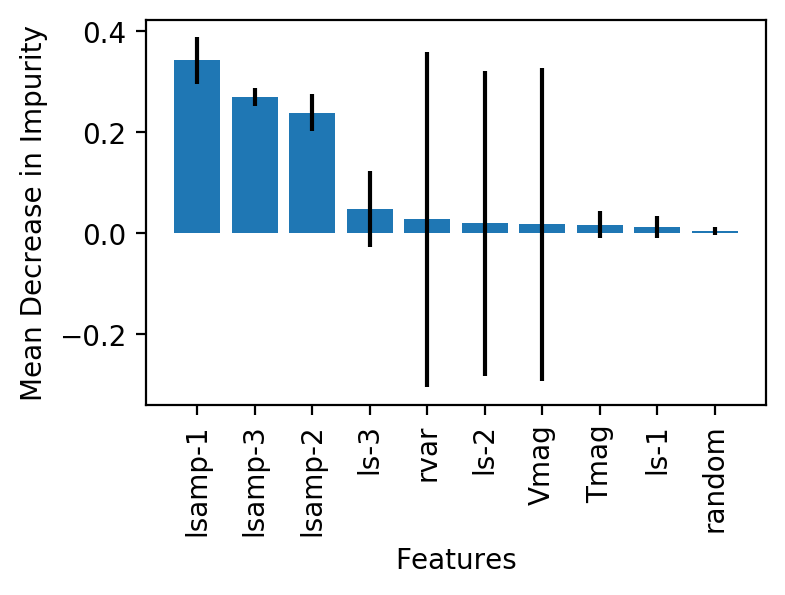

In [4]:
#feature importances plots

#determine order
rf1_imps=[]
for i in rf1_feature_imp.index:
    i = i.split("_")
    i = i[0]
    rf1_imps.append(i)
## attribute feature_importances_  are computed as the mean and standard
#  deviation of accumulation of the impurity decrease within each tree.
# Warning: b/c my features have high cardinality (many unique values) this way can be misleading
# THIS maybe why std is so large for some features
#plot
plt.figure(figsize=(4,2.5),dpi=200)

plt.bar(rf1_imps, rf1_feature_imp.values, yerr=std_1 ) #with error bars
# plt.bar(rf1_imps, rf1_feature_imp.values )

plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=90);
plt.show()
# plt.title("RF-1 Model Feature Importance"); #paper figures dont need titles

# RF-2 model

In [5]:
## RF-2

print('starting RF-2')
#select features
# rf2_features = examples[(examples['CLASS']==1) | (examples['CLASS']==3)]
rf2_features = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/rf2_training.csv')#includes ncvz google df & tois in rf2
rf2_short_features_nans = rf2_features[rf2_features_list]
rf2_short_features = rf2_short_features_nans.dropna()
rf2_nan_exs_loss = len(rf2_short_features_nans) - len(rf2_short_features)
np.random.seed(seed = 11)
rf2_short_features['random'] = np.random.random(size = len(rf2_short_features))
#model prep summary
rf2_final_labels = rf2_short_features['CLASS'].to_numpy()
rf2_final_features = rf2_short_features.drop(columns=['CLASS'])
rf2_NOtransit_train = len(rf2_final_labels[rf2_final_labels==1])
rf2_YEStransit_train = len(rf2_final_labels[rf2_final_labels==3])
#model
rf2_X = rf2_final_features.copy()
rf2_y = rf2_final_labels
X_train2, test_X2, y_train2, test_y2 = train_test_split(rf2_X, rf2_y, random_state = 11)
rf2_model = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
rf2_model.fit(X_train2, y_train2)
rf2_test_acc = rf2_model.score(test_X2,test_y2)
rf2_train_acc = rf2_model.score(X_train2,y_train2)
rf2_oob_score = rf2_model.oob_score_
#cv was here
print('starting summary stats')
#feature importance
rf2_feature_imp = pd.Series(rf2_model.feature_importances_,index=list(rf2_X.columns)).sort_values(ascending=False)
std_2 = np.std([
    tree.feature_importances_ for tree in rf2_model.estimators_], axis=0)

#predict for unseen data
rf2_allstats_features = allstats[list(rf2_final_features.columns)] #select features used by rf2
all_forRF2 = rf2_allstats_features.dropna() #drop nans
rf2_nan_loss = len(rf2_allstats_features) - len(all_forRF2)
rf2_predictions = rf2_model.predict(all_forRF2) #make predictions
all_forRF2['RF2predict_class'] = rf2_predictions #add to df
RF2_master_data = RF1_master_data.join(all_forRF2['RF2predict_class']) #merge results to master df
#summarize RF-2 results proceeding to RF-3
rf1_goodcut = (RF2_master_data['RF1predict_class']==1.0) #periodic
rf2_goodcut = (RF2_master_data['RF2predict_class']==1.0) #no transit
rf2_badcut = (RF2_master_data['RF2predict_class']==3.0) #transiting
rf2_allpassed_rf1_total = RF2_master_data[rf1_goodcut]
rf2_good_allpredictions = RF2_master_data[rf1_goodcut & rf2_goodcut] #passed RF 1 & RF 2
rf2_bad_allpredictions = RF2_master_data[rf1_goodcut & rf2_badcut] #passed RF 1 & failed RF 2
NOtransits_percent = ( len(rf2_good_allpredictions)/ len(rf2_allpassed_rf1_total) ) * 100
YEStransits_percent = ( len(rf2_bad_allpredictions)/ len(rf2_allpassed_rf1_total) ) * 100
print('finished')

starting RF-2
starting summary stats
finished


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


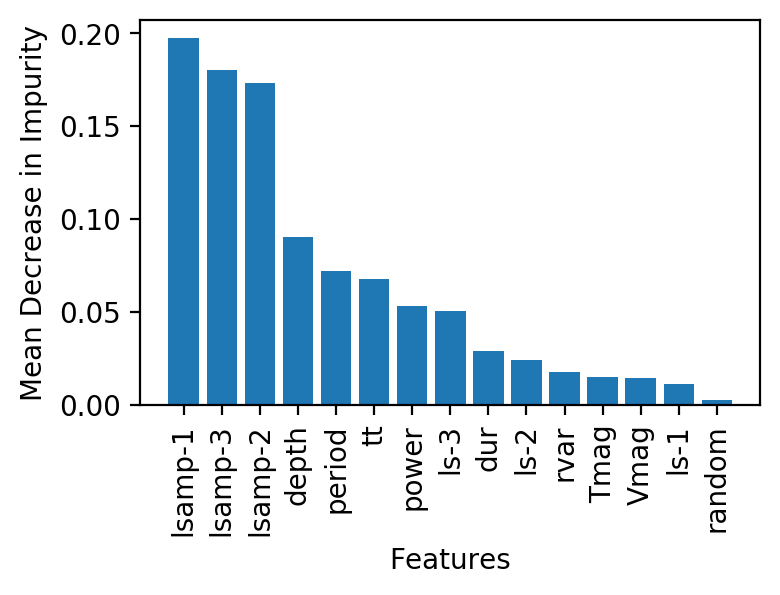

In [11]:
#feature importances plots

#determine order
rf2_imps=[]
for i in rf2_feature_imp.index:
    i = i.split("_")
    i = i[0]
    rf2_imps.append(i)
## attribute feature_importances_  are computed as the mean and standard
#  deviation of accumulation of the impurity decrease within each tree.
# Warning: b/c my features have high cardinality (many unique values) this way can be misleading
#plot
plt.figure(figsize=(4,2.5),dpi=200)

# plt.bar(rf2_imps, rf2_feature_imp.values, yerr=std_2 ) #with error bars
plt.bar(rf2_imps, rf2_feature_imp.values )

plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=90);

plt.show()

# RF-3 model

In [7]:
## RF-3

print('starting RF-3')
#load data
half_as = 'uses halves as BAD'
# rf3_features = pd.read_csv('data/cvz_mq_examples_forRF3.csv') #full train set (mq & cvz examples with teff/giants cuts done)
rf3_features = pd.read_csv('/Volumes/Seagate-stars/Final_Run/test_sets/rf3_training.csv') #includes ncvz google df & tois in rf2
#select features
rf3_short_features_nans = rf3_features[rf3_features_list]
rf3_short_features = rf3_short_features_nans.dropna()
rf3_nan_exs_loss = len(rf3_short_features_nans) - len(rf3_short_features)
#model prep summary
np.random.seed(seed = 11) #inject random number
rf3_short_features['random'] = np.random.random(size = len(rf3_short_features))
rf3_final_labels = rf3_short_features['Label'].to_numpy()
rf3_final_features = rf3_short_features.drop(columns=['Label'])
rf3_GOODrp_train = len(rf3_short_features[rf3_short_features['Label'].to_numpy()==3])
rf3_BADrp_train = len(rf3_short_features[rf3_short_features['Label'].to_numpy()==1])
#model
rf3_x = rf3_final_features 
rf3_y = rf3_final_labels
x_train3, test_x3, y_train3, test_y3 = train_test_split(rf3_x, rf3_y, random_state = 11)
rf3_model = RandomForestClassifier(n_estimators = 200,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
rf3_model.fit(x_train3, y_train3)
rf3_test_acc = rf3_model.score(test_x3,test_y3)
rf3_train_acc = rf3_model.score(x_train3,y_train3)
rf3_oob_score = rf3_model.oob_score_
#cv was here
print('starting summary stats')
#feature importance
rf3_feature_imp = pd.Series(rf3_model.feature_importances_,index=list(rf3_x.columns)).sort_values(ascending=False)
std_3 = np.std([
    tree.feature_importances_ for tree in rf3_model.estimators_], axis=0)


#predict for unseen data
rf3_allstats_features = allstats[list(rf3_final_features.columns)] #select features
all_forRF3 = rf3_allstats_features.dropna()  #drop nans
rf3_nan_loss = len(rf3_allstats_features) - len(all_forRF3)
rf3_predictions = rf3_model.predict(all_forRF3) #make predictions
all_forRF3['RF3predict_class'] = rf3_predictions #add to df
RF3_master_data = RF2_master_data.join(all_forRF3['RF3predict_class']) #merge to master df
#summarize RF-3 results & final results
rf1_goodcut = (RF3_master_data['RF1predict_class']==1.0) #periodic
rf2_goodcut = (RF3_master_data['RF2predict_class']==1.0) #no transit
rf3_goodcut = (RF3_master_data['RF3predict_class']==3.0) #good Prot
rf3_badcut = (RF3_master_data['RF3predict_class']==1.0) #bad Prot
rf3_good_allpredictions = RF3_master_data[rf1_goodcut & rf2_goodcut & rf3_goodcut] #passed RF 1&2&3
rf3_bad_allpredictions = RF3_master_data[rf1_goodcut & rf2_goodcut & rf3_badcut] #passed RF 1&2 but failed RF 3
rf3_allpassed_rf1n2_total = RF3_master_data[rf1_goodcut & rf2_goodcut]
goods_percent = (len(rf3_good_allpredictions) / len(rf3_allpassed_rf1n2_total) ) * 100
bads_percent = (len(rf3_bad_allpredictions) / len(rf3_allpassed_rf1n2_total) ) * 100
print('finished')


starting RF-3


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


starting summary stats
finished


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


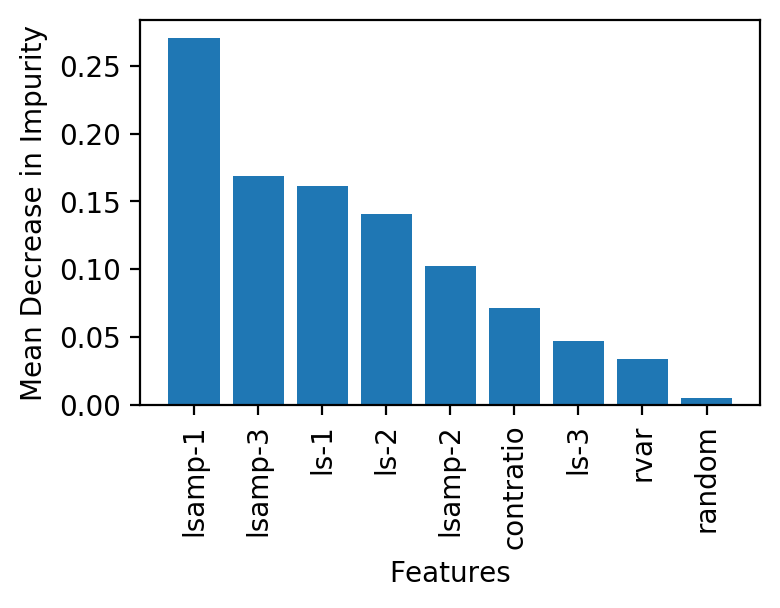

In [10]:
#feature importances plots

#determine order
rf3_imps=[]
for i in rf3_feature_imp.index:
    i = i.split("_")
    i = i[0]
    rf3_imps.append(i)
## attribute feature_importances_  are computed as the mean and standard
#  deviation of accumulation of the impurity decrease within each tree.
# Warning: b/c my features have high cardinality (many unique values) this way can be misleading
#plot
plt.figure(figsize=(4,2.5),dpi=200)

# plt.bar(rf3_imps, rf3_feature_imp.values, yerr=std_3 ) #with error bars
plt.bar(rf3_imps, rf3_feature_imp.values )

plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=90);
plt.show()
